# Choosing the best subreddit to post in based on two chosen category!

## Table of Content

1. [Retrieving Posts](#1)
2. [Word/Tag Cloud](#2)
3. [Preprocessing](#3)
4. [Modeling the data](#4) <br/>
    4.1  Logistic Regression and TFIDF Model <br/>
    4.2 Naive Bayes and TFIDF Model <br/>
    4.3 Logistic Regression and CountVectorizer Model <br/>
    4.4 Naive Bayes and CountVectorizer Model <br/>
    4.5 Random Forest Classifier Model with TFIDF <br/>
    
    

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns

#API 
import requests

#Automating
import time
import datetime
import warnings
import sys

#sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix

#Saving and chaching
import dill
from ediblepickle import checkpoint #caching the results of function calls
import os

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

<a class="anchor" id="1"></a>

# 1. Getting posts from a subreddit in Reddit 

one way to access reddit posts is using the API directly via https://pushshift.io/

Developing a function to get all posts for a defined subreddit.In order to this task I got help from instruction in https://github.com/pushshift/api and also from following website https://chatbotslife.com/nlp-classification-part-1-f0034d0a64a3.

In [3]:
# cache_dir = 'cache'
# if not os.path.exists(cache_dir):
#     os.mkdir(cache_dir)

# @checkpoint(key=lambda args, kwargs: quote(args[0]+'_'+args[1]+'_'+args[2]) + '.pkl', work_dir=cache_dir)
def get_posts(subreddit, n_iter, current_epoch): # subreddit name and number of times function should run
    
    base_url = 'https://api.pushshift.io/reddit/search/submission/?subreddit='
    df_list = []
    epoch_time = current_epoch
    
    for post in range(n_iter):
        
        res = requests.get(base_url,
                           #Pushshift Reddit Parameters
                            params = {'subreddit' : subreddit,
                                        'size' : 100, # number of posts to return each time
                                        'lang' : True, #default language of the subreddit
                                        'before' : current_time # Return results before this date
                                     })

        df = pd.DataFrame(res.json()['data']) # store each request as df
        
        # choose columns of interest
        df = df.loc[:, ['title',
                        'created_utc',  # submission UTC timestamp
                        'selftext',
                        'subreddit',
                        'author',
                        'media_only',
                        'permalink' # permanent link to a specific comment
                       ]]
        
        df_list.append(df)
        time.sleep(30) # 30 seconds delay to prevent break
        
        # update epoch time to the last UTC submission post in recently grabbed df
        epoch_time = df['created_utc'].min() 
        
    return pd.concat(df_list, axis=0)


In [4]:
# Get current timestamp using time module
import time
  
# ts stores the time in seconds
ts = time.time()
  
# print the current timestamp
print(f'the current timestamp is {ts}')

the current timestamp is 1655135330.4595609


Getting posts of two popular subreddits gaming (Entertainment - Gaming) and Music (Entertainment - Other (Movies/Music/Franchies/Misc)) from current epoch of 1652220674 up until 10,000 posts (100 iterate everytime 100 posts, totally 10000 posts for each subreddit).

### Gaming dataset

In [5]:
# # get posts of subreddit gaming from current epoch of 1652052525 up until 10,000 posts.
# %time
# gaming_df=get_posts(subreddit=['gaming'], n_iter=200, epoch_right_now=1652052525)

Saving all posts in a pickle files or each subreddit.

In [6]:
#dill.dump(gaming_df, open('gaming_df.pkd', 'wb'))

In [7]:
gaming_df= dill.load(open('gaming_df.pkd', 'rb'))

In [8]:
gaming_df['selftext'].value_counts() #12364 records, 3903 removed, 73 deleted

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          12364
[removed]               

As we see, here we have [removed] and [deleted] in our dataset which we have to take care of.

### Music dataset

In [9]:
# # get posts of subreddit gaming from current epoch of 1652052525 up until 20,000 posts.
# %time
# music_df=get_posts(subreddit=['Music'], n_iter=200, epoch_right_now=1652052525)

In [10]:
# dill.dump(music_df, open('music_df.pkd', 'wb'))

In [11]:
music_df= dill.load(open('music_df.pkd', 'rb'))

In [12]:
music_df['selftext'].value_counts() #12703 records, 3456 removed, 73 deleted

### Technology dataset

In [13]:
# # get posts of subreddit gaming from current epoch of 1652052525 up until 20,000 posts.
# %time
# technology_df=get_posts(subreddit=['technology'], n_iter=200, epoch_right_now=1652052525)

In [14]:
#dill.dump(technology_df, open('technology_df.pkd', 'wb'))

In [15]:
technology_df= dill.load(open('technology_df.pkd', 'rb'))

In [16]:
technology_df['selftext'].value_counts()

### Politics dataset

In [17]:
# # get posts of subreddit gaming from current epoch of 1652052525 up until 20,000 posts.
# %time
# politics_df=get_posts(subreddit=['politics'], n_iter=200, epoch_right_now=1652052525)

In [18]:
#dill.dump(politics_df, open('politics_df.pkd', 'wb'))

In [19]:
politics_df= dill.load(open('politics_df.pkd', 'rb'))

In [20]:
#technology 

In [21]:
politics_df['selftext'].value_counts()

#### 1.1 Making a table of information on post dataframes 

In [22]:
d = {'observations':[20000-len(gaming_df[gaming_df['selftext']=='[deleted]'])-len(gaming_df[gaming_df['selftext']=='[removed]']),
                    20000-len(music_df[music_df['selftext']=='[deleted]'])-len(music_df[music_df['selftext']=='[removed]']),
                    20000-len(technology_df[technology_df['selftext']=='[deleted]'])-len(technology_df[technology_df['selftext']=='[removed]']),
                    20000-len(politics_df[politics_df['selftext']=='[deleted]'])-len(politics_df[politics_df['selftext']=='[removed]'])],
     'Removed': [len(gaming_df[gaming_df['selftext']=='[removed]']),
                len(music_df[music_df['selftext']=='[removed]']),
                len(technology_df[technology_df['selftext']=='[removed]']),
                len(politics_df[politics_df['selftext']=='[removed]'])],
     'deleted': [len(gaming_df[gaming_df['selftext']=='[deleted]']),
                len(music_df[music_df['selftext']=='[deleted]']),
                len(technology_df[technology_df['selftext']=='[deleted]']),
                len(politics_df[politics_df['selftext']=='[deleted]'])]}
pd.DataFrame(data=d, index=['Gaming', 'Music', 'Technology', 'Politics'])

,observations,Removed,deleted
Gaming,15955,3903,142
Music,16471,3456,73
Technology,14421,5324,255
Politics,19628,21,351


In [23]:
len(politics_df[politics_df['selftext']=='[deleted]'])

351

In [24]:
music_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19991 entries, 0 to 98
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        19991 non-null  object
 1   created_utc  19991 non-null  int64 
 2   selftext     19967 non-null  object
 3   subreddit    19991 non-null  object
 4   author       19991 non-null  object
 5   media_only   19991 non-null  bool  
 6   permalink    19991 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 1.1+ MB


In [25]:
gaming_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19971 entries, 0 to 99
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        19971 non-null  object
 1   created_utc  19971 non-null  int64 
 2   selftext     19937 non-null  object
 3   subreddit    19971 non-null  object
 4   author       19971 non-null  object
 5   media_only   19971 non-null  bool  
 6   permalink    19971 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 1.1+ MB


In [26]:
gaming_df.head(3)

,title,created_utc,selftext,subreddit,author,media_only,permalink
0,What game was first to have decision based gam...,1652052321,,gaming,Jumpout223,False,/r/gaming/comments/uldyto/what_game_was_first_...
1,what was the last console that u bought?,1652052028,mines was the xbox series s for the guest bath...,gaming,TheTruth221,False,/r/gaming/comments/uldvmq/what_was_the_last_co...
2,"FN++100++Skin,+Rick+Sanchez,+Morty,+Midas,+Mar...",1652051940,,gaming,Majestic-Ad-2823,False,/r/gaming/comments/uldunc/fn100skinricksanchez...


In [27]:
# #exporting to csv file
# music_df.to_csv('music_df.csv')

# gaming_df.to_csv('gaming_df.csv')

# politics_df.to_csv('gaming_df.csv')

# technology_df.to_csv('technology_df.csv')

In [28]:
# creating the target value
technology_df['technology']=1
politics_df['technology']=0

In [29]:
# creating the target value
gaming_df['gaming']=1
music_df['gaming']=0

In [30]:
#Merging two dataframes

comb_df=gaming_df.append(music_df, sort=True)
comb_df.drop(columns=['permalink'], inplace=True)

<ipython-input-30-07b847d408e7>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comb_df=gaming_df.append(music_df, sort=True)


In [31]:
comb_df.shape

(39962, 7)

In [32]:
comb_df.drop_duplicates(subset='title', inplace=True)

In [33]:
comb_df.shape

(37242, 7)

In [34]:
comb_df_tp=technology_df.append(politics_df, sort=True)
comb_df_tp.drop(columns=['permalink'], inplace=True)

<ipython-input-34-8215d31a6e84>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comb_df_tp=technology_df.append(politics_df, sort=True)


In [35]:
comb_df_tp.shape

(39964, 7)

In [36]:
comb_df_tp.drop_duplicates(subset='title', inplace=True)

In [37]:
comb_df_tp.shape

(36390, 7)

In [38]:
comb_df.head(2)

,author,created_utc,gaming,media_only,selftext,subreddit,title
0,Jumpout223,1652052321,1,False,,gaming,What game was first to have decision based gam...
1,TheTruth221,1652052028,1,False,mines was the xbox series s for the guest bath...,gaming,what was the last console that u bought?


In [39]:
comb_df_tp.head(2)

,author,created_utc,media_only,selftext,subreddit,technology,title
0,ChickenTeriyakiBoy1,1652051927,False,,technology,1,UK YouTuber Benjamin Rich held at Russian spac...
1,Conscious_Fig7047,1652048884,False,[removed],technology,1,Computer programming


In [40]:
#let's export it to csv and then examine it
comb_df.to_csv('comb_df_gm.csv')
comb_df_tp.to_csv('comb_df_tp.csv')

In [41]:
comb_df.isnull().sum()

author          0
created_utc     0
gaming          0
media_only      0
selftext       47
subreddit       0
title           0
dtype: int64

In [42]:
comb_df.isnull().sum()

author          0
created_utc     0
gaming          0
media_only      0
selftext       47
subreddit       0
title           0
dtype: int64

### Checking if the data is balanced

As we see, data is balanced

In [43]:
comb_df['gaming'].value_counts(normalize=True)

1    0.501987
0    0.498013
Name: gaming, dtype: float64

In [44]:
comb_df_tp['technology'].value_counts(normalize=True)

1    0.511542
0    0.488458
Name: technology, dtype: float64

<a class="anchor" id="2"></a>

## 2. Word/Tag Cloud

Plotting most common words before preprocessing (in order to visualize importance of preprocessing).

> To show our keyword metadata, Tag cloud is used. Tags are usually single words, and the importance of each tag is shown with font size or color. 

In [45]:
'''
source to cloud word and imaging:
https://re-thought.com/creating-wordclouds-in-python/
'''
from wordcloud import WordCloud, get_single_color_func, ImageColorGenerator, STOPWORDS
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

stopwords= set(STOPWORDS)

def show_wordcloud(data,name='', title=None):
    wordcloud = WordCloud(
        background_color='black',
        colormap='Set2',
        stopwords=stopwords,
        max_words=500,
        max_font_size=70, 
        scale=5,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=3)

    plt.imshow(wordcloud)
    plt.show()
    plt.savefig(f"{name}.png", format="png") # Save the image

In [46]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nazlirafei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

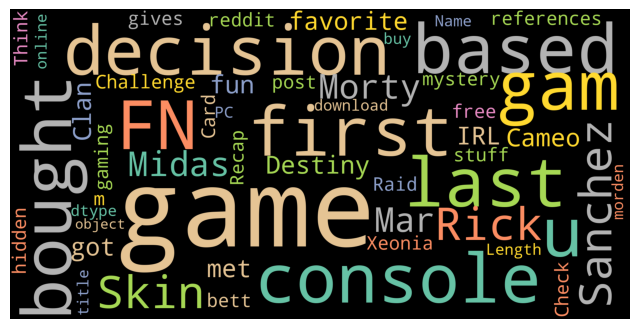

In [47]:
#word cloud for 
show_wordcloud(gaming_df['title'],name='gaming')

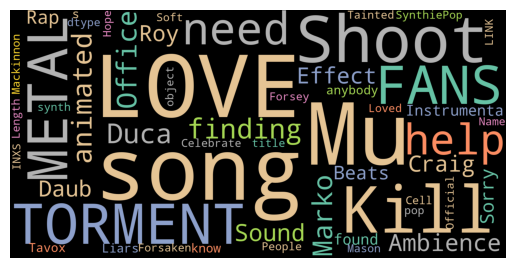

In [48]:
show_wordcloud(music_df['title'],name='music')


In [49]:
#show_wordcloud(politics_df['title'],name='politics')

In [50]:
#show_wordcloud(technology_df['title'],name='technology')

<a class="anchor" id="3"></a>

# 3. Preprocessing the data

In [51]:
comb_df.index.unique()

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
            86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 70],
           dtype='int64')

In [52]:
# #Getting 3 columns of author and is_motivating and title and making author is the index column
# comb_df= comb_df[['gaming', 'title', 'author']]
# comb_df.set_index('author', inplace=True)
# comb_df

### Preprocessing the text

#### https://www.analyticsvidhya.com/blog/2021/08/a-friendly-guide-to-nlp-text-pre-processing-with-python-example/

* Remove links
* Remove punctuations
* Remove numbers
* Remove emojis
* Remove stop words

#### Remove links

In [53]:
from bs4 import BeautifulSoup
import re

In [54]:
comb_df["title"] =comb_df["title"].apply(lambda s: ' '.join(re.sub("(w+://S+)", " ", s).split()))

#### Remove punctuations

In [55]:
#comb_df["title"] =  comb_df["title"].apply(lambda s: ' '.join(re.sub("[+.,!?:;-='...\"@#_]", " ", s).split()))


#### Remove numbers

In [56]:
comb_df["title"] = comb_df["title"].str.replace('\d+', '', regex=True)

#### Remove emojis

In [57]:
def deEmojify(inputString):
    if inputString is not None:
        return inputString.encode('ascii', 'ignore').decode('ascii')
    else:
        return inputString

comb_df["title"] =  comb_df["title"].apply(lambda s: deEmojify(s) )


In [58]:
comb_df['title']

0     What game was first to have decision based gam...
1              what was the last console that u bought?
2     FN++++Skin,+Rick+Sanchez,+Morty,+Midas,+Marvel...
3     My Destiny Clan met IRL and I got a fun Cameo ...
4     What is your favorite mystery in a game? For m...
                            ...                        
94                       Tavox - The Liars [SynthiePop]
95    "We Hope That People Loved It": INXS Celebrate...
96    Mason Forsey Mackinnon - Forsaken [Official Mu...
97                                                 LINK
98                 Soft Cell - Tainted Love [synth-pop]
Name: title, Length: 37242, dtype: object

### Drop all rows which their title value is empty

In [59]:
#comb_df = comb_df.dropna()

#### Deviding data into train test split

In [60]:
comb_df.reset_index(drop=True, inplace=True)

In [61]:
comb_df

,author,created_utc,gaming,media_only,selftext,subreddit,title
0,Jumpout223,1652052321,1,False,,gaming,What game was first to have decision based gam...
1,TheTruth221,1652052028,1,False,mines was the xbox series s for the guest bath...,gaming,what was the last console that u bought?
2,Majestic-Ad-2823,1652051940,1,False,,gaming,"FN++++Skin,+Rick+Sanchez,+Morty,+Midas,+Marvel..."
3,kazbeh,1652051918,1,False,,gaming,My Destiny Clan met IRL and I got a fun Cameo ...
4,Felizem_velair_,1652051897,1,False,,gaming,What is your favorite mystery in a game? For m...
...,...,...,...,...,...,...,...
37237,Tavox_AtropinSound,1649118131,0,False,,Music,Tavox - The Liars [SynthiePop]
37238,diemonsterdie,1649118094,0,False,,Music,"""We Hope That People Loved It"": INXS Celebrate..."
37239,Famous_Look_4326,1649117984,0,False,,Music,Mason Forsey Mackinnon - Forsaken [Official Mu...
37240,BAHRAM2ROO,1649117804,0,False,[removed],Music,LINK


 > Train - Test split

In [62]:
X=comb_df['title']
y=comb_df['gaming']

In [63]:
X_tp=comb_df_tp['title']
y_tp=comb_df_tp['technology']

In [64]:
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42, stratify=y)

In [65]:
#X_train_tp, X_test_tp, y_train_tp, y_test_tp=train_test_split(X_tp, y_tp, test_size=0.30, random_state=42, stratify=y)

In [66]:
comb_df.isnull().sum()

author          0
created_utc     0
gaming          0
media_only      0
selftext       47
subreddit       0
title           0
dtype: int64

#### Adding more stop words

In [67]:
# Perform standard imports:
import spacy
nlp = spacy.load('en_core_web_sm')

In [68]:
# Add the list of words to the set of stop words. 
from spacy.lang.en.stop_words import STOP_WORDS

STOP_WORDS = STOP_WORDS.union({'ll', 've',"`","’","n't"})

In [69]:
X

0        What game was first to have decision based gam...
1                 what was the last console that u bought?
2        FN++++Skin,+Rick+Sanchez,+Morty,+Midas,+Marvel...
3        My Destiny Clan met IRL and I got a fun Cameo ...
4        What is your favorite mystery in a game? For m...
                               ...                        
37237                       Tavox - The Liars [SynthiePop]
37238    "We Hope That People Loved It": INXS Celebrate...
37239    Mason Forsey Mackinnon - Forsaken [Official Mu...
37240                                                 LINK
37241                 Soft Cell - Tainted Love [synth-pop]
Name: title, Length: 37242, dtype: object

In [70]:
nlp.vocab['btw'].is_stop

False

#### Check to see if there is any blank

In [71]:
# blanks = []  # start with an empty list

# for i,rv,auth in comb_df[['title', 'author']].itertuples():  # iterate over the DataFrame
#     if type(rv)==str:            # avoid NaN values
#         if rv.isspace():         # test 'review' for whitespace
#             blanks.append(i)     # add matching index numbers to the list
        
# print(len(blanks), 'blanks: ', blanks)

In [72]:
#NLTK's snowballStemmer
from nltk.stem.snowball import SnowballStemmer

# The Snowball Stemmer requires that you pass a language parameter
s_stemmer = SnowballStemmer(language='english')

In [73]:
# get this code from http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
from textblob import TextBlob

# Use TextBlob
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())#stemmer=SnowballStemmer) # establish a TextBlob object
    tokens = blob.words # Word tokenization of input (str)
    words = [token.stem() for token in tokens] 
    return words

> Fitting a count vectorizer to find the most popular words

In [74]:
''' 
1- instantiate a count vectorizer
2- fit and transform our model on CountVectorizer to find most popular words

'''
cv=CountVectorizer(
        analyzer='word',
        tokenizer=textblob_tokenizer,
        preprocessor= None,
        stop_words=STOP_WORDS)

In [75]:
X_train_cv=cv.fit_transform(X_train)
X_test_cv=cv.transform(X_test)
X_train_cv

/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'd', 'doe', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'm', 'mani', 'meanwhil', 'moreov', 'mostli', 'n', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'quit', 'realli', 'regard', 's', 'seriou', 'sever', 'sinc', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 't', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'use', 'variou', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 

<27931x22265 sparse matrix of type '<class 'numpy.int64'>'
	with 160730 stored elements in Compressed Sparse Row format>

In [76]:
print(X_train_cv.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [77]:
# make a dataframe from countvectorizer preprocess
counts = pd.DataFrame(X_train_cv.toarray(),
                  columns=cv.get_feature_names())

counts.head()

/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,''dip,''hot,''rema,''splash,'africa,'ai,'airoheart,'aliv,'all,'an,...,zuu,zwan,zwv,zx,zyde,zydeco,zyl,zyzz,zz,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
#visualizing our train data set
cv_df= pd.DataFrame(X_train_cv.todense(),
                     columns=cv.get_feature_names())

cv_df

/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,''dip,''hot,''rema,''splash,'africa,'ai,'airoheart,'aliv,'all,'an,...,zuu,zwan,zwv,zx,zyde,zydeco,zyl,zyzz,zz,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27926,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27927,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27928,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
columns=cv.get_feature_names()
len(columns)

/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


22265

In [80]:
counts[['game', 'thi', 'play', 'like', 'video', 'ps', 'new']].sum()

game     4794
thi      2468
play     1299
like     1090
video    1000
ps        487
new      1163
dtype: int64

In [81]:
X_train.index

Int64Index([ 4657, 31405, 34168,  6833, 18120, 31684,  9606, 16846, 32048,
            25926,
            ...
            31737, 21826,  9271,  7898, 12322,  8711, 34773,  6824,  8471,
            20247],
           dtype='int64', length=27931)

In [82]:
X_train_cv

<27931x22265 sparse matrix of type '<class 'numpy.int64'>'
	with 160730 stored elements in Compressed Sparse Row format>

### Game data

#### Turn the results into a format we can understand

In [83]:
#https://investigate.ai/text-analysis/counting-words-with-scikit-learns-countvectorizer/
game_vect=pd.DataFrame(X_train_cv.todense(),
                        columns=cv.get_feature_names(), index=X_train.index).reindex(y_train[y_train == 1].index)

/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [84]:
top_game_words= game_vect.mean().sort_values(ascending=False).iloc[:15]
top_game_words.values

array([0.3366379 , 0.09799586, 0.08109265, 0.0402967 , 0.03623137,
       0.03466229, 0.03409172, 0.03202339, 0.03152414, 0.02824335,
       0.02817203, 0.02802938, 0.02731617, 0.02681692, 0.0261037 ])

In [85]:
top_game_words=top_game_words.sort_values(ascending=False)
top_game_words


game     0.336638
thi      0.097996
play     0.081093
like     0.040297
video    0.036231
ps       0.034662
new      0.034092
look     0.032023
wa       0.031524
ani      0.028243
best     0.028172
help     0.028029
good     0.027316
pc       0.026817
time     0.026104
dtype: float64

In [86]:
top_game_words_count= game_vect.sum().sort_values(ascending=False).iloc[:15]
df = pd.DataFrame(top_game_words_count.sort_values(ascending=False), columns=[ 'Count'])
df.index.name = 'word'

In [87]:
df

,Count
word,
game,4720
thi,1374
play,1137
like,565
video,508
ps,486
new,478
look,449
wa,442


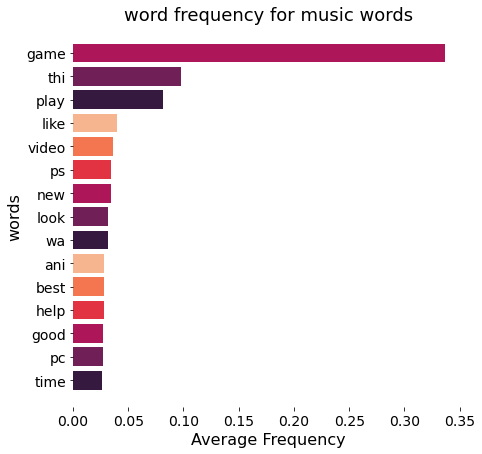

In [88]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,7))

top_game_words=top_game_words.sort_values(ascending=True)
plt.barh(top_game_words.index, top_game_words.values, color=sns.color_palette("rocket"))
plt.title('word frequency for music words', fontsize=18)
sns.despine(left=True, bottom=True)
plt.ylabel("words", fontsize=16)
plt.xlabel('Average Frequency', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

### Music data

In [89]:
#https://investigate.ai/text-analysis/counting-words-with-scikit-learns-countvectorizer/
music_vect=pd.DataFrame(X_train_cv.todense(),
                        columns=cv.get_feature_names(), index=X_train.index).reindex(y_train[y_train == 0].index)

/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [90]:
music_vect.mean().sort_values(ascending=False)

song         0.150467
music        0.134795
rock         0.080158
thi          0.078648
new          0.049245
               ...   
odpocinek    0.000000
odst         0.000000
oem          0.000000
off-bal      0.000000
owww         0.000000
Length: 22265, dtype: float64

In [91]:
top_music_words= music_vect.mean().sort_values(ascending=False).iloc[:15]
top_music_words.values

array([0.15046729, 0.13479511, 0.08015816, 0.07864845, 0.04924515,
       0.04680086, 0.04090582, 0.03774263, 0.03537024, 0.03450755,
       0.02897196, 0.02839684, 0.02760604, 0.02688713, 0.02667146])

In [92]:
top_music_words=top_music_words.sort_values(ascending=False)
top_music_words

song      0.150467
music     0.134795
rock      0.080158
thi       0.078648
new       0.049245
amp       0.046801
pop       0.040906
like      0.037743
video     0.035370
album     0.034508
love      0.028972
rap       0.028397
band      0.027606
listen    0.026887
best      0.026671
dtype: float64

In [93]:
top_music_words_count= music_vect.sum().sort_values(ascending=False).iloc[:15]
df = pd.DataFrame(top_music_words_count.sort_values(ascending=False), columns=[ 'Count'])
df.index.name = 'word'

In [94]:
df

,Count
word,
song,2093
music,1875
rock,1115
thi,1094
new,685
amp,651
pop,569
like,525
video,492


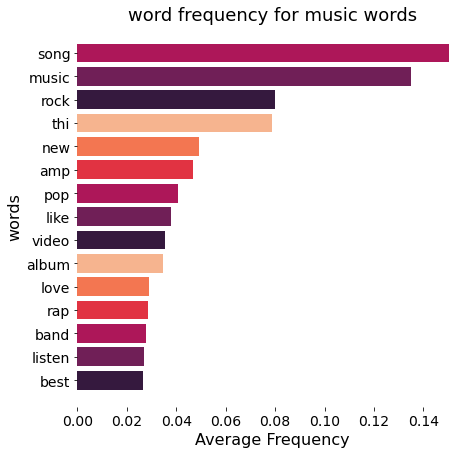

In [95]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,7))

top_music_words=top_music_words.sort_values(ascending=True)
plt.barh(top_music_words.index, top_music_words.values, color=sns.color_palette("rocket"))
plt.title('word frequency for music words', fontsize=18)
sns.despine(left=True, bottom=True)
plt.ylabel("words", fontsize=16)
plt.xlabel('Average Frequency', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

<a class="anchor" id="4"></a>

# 4. Modeling

Logistic Regression,Naive Bayes, Random Forest, TF-IDF and GridSearchCV

In [96]:
# helper function for outputing classification results
def praf1(y_true, y_pred, name):
    """Return precision, recall, accuracy, and f1_score for a classifier
    Can either output as a dictionary or print to stdout"""
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    a = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    results = dict(precision=p, recall=r, accuracy=a, f1=f1)
    return pd.DataFrame(results, index=[name])

#### Preprocessing: TF-IDF Tool (term frequency–inverse document frequency)

In [97]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [98]:
# Add the list of words to the set of stop words. 
from spacy.lang.en.stop_words import STOP_WORDS

STOP_WORDS = STOP_WORDS.union({'ll', 've',"`","’","n't",'ani','wa','thi','ha','whi','doe','x','ai'})

In [99]:
# get this code from http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
from textblob import TextBlob

# Use TextBlob
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())#stemmer=SnowballStemmer) # establish a TextBlob object
    tokens = blob.words # Word tokenization of input (str)
    words = [token.stem() for token in tokens] 
    return words

In [100]:
#Instantiating and fitting the TFIDF model
tfidf= TfidfVectorizer(analyzer='word',
                     tokenizer=textblob_tokenizer,
                     preprocessor=None,
                     stop_words=STOP_WORDS)

X_train_tfidf=tfidf.fit_transform(X_train)
X_test_tfidf=tfidf.transform(X_test)
X_train_tfidf

<27931x22257 sparse matrix of type '<class 'numpy.float64'>'
	with 155539 stored elements in Compressed Sparse Row format>

In [101]:
tfidf_df= pd.DataFrame(X_train_tfidf.todense(),
                     columns=tfidf.get_feature_names())

tfidf_df.head()

/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,''dip,''hot,''rema,''splash,'africa,'ai,'airoheart,'aliv,'all,'an,...,zuu,zwan,zwv,zx,zyde,zydeco,zyl,zyzz,zz,zzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1- Modeling: Logistic Regression and TFIDF Model

In [102]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score,plot_roc_curve
from sklearn.metrics import classification_report

In [103]:
lr=LogisticRegression(random_state=42)

lr.fit(X_train_tfidf, y_train)

print(f'Logistic Regression and TFIDF Model Score on Training Set :{lr.score(X_train_tfidf, y_train)}')
print(f'Logistic Regression and TFIDF Model Score on Testing Set :{lr.score(X_test_tfidf, y_test)}')

Logistic Regression and TFIDF Model Score on Training Set :0.9554616734094733
Logistic Regression and TFIDF Model Score on Testing Set :0.9066695306626571


In [104]:
param_grid = {
    'solver' :['newton-cg', 'lbfgs', 'liblinear'],
    'penalty' : ['l2','l1','None'] ,
    "C": [100, 10, 1.0, 0.1, 0.01],
    "fit_intercept": [True, False]
            }

In [105]:
# import sklearn
# sklearn.metrics.SCORERS.keys()

In [106]:
grid_search_lr = GridSearchCV(lr, param_grid, scoring="accuracy", n_jobs=-1, return_train_score=True)
grid_search_lr.fit(X_train_tfidf, y_train)

GridSearchCV(estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'fit_intercept': [True, False],
                         'penalty': ['l2', 'l1', 'None'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             return_train_score=True, scoring='accuracy')

In [107]:
grid_search_lr.best_params_

{'C': 1.0, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear'}

#### Gaming = 1

/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


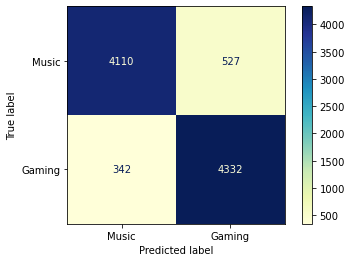

In [108]:
plot_confusion_matrix(grid_search_lr, X_test_tfidf, y_test, cmap='YlGnBu', display_labels=['Music', 'Gaming'] );

In [110]:
train_pred_lr = grid_search_lr.predict(X_train_tfidf)
test_pred_lr = grid_search_lr.predict(X_test_tfidf)

auc=roc_auc_score(y_test, test_pred_lr)
acc = accuracy_score(y_test, test_pred_lr )
prec = precision_score(y_test, test_pred_lr)
rec = recall_score(y_test, test_pred_lr )
f1 = f1_score(y_test, test_pred_lr)

results = pd.DataFrame([['Logistic Regression-TFIDF',  acc,auc, prec, rec, f1]], 
                           columns = ['Model','Accuracy','AUC', 'Precision', 'Recall', 'F1 Score'])

results = results.sort_values(["Accuracy","AUC","Precision", "Recall"], ascending = False)
print (results)

                       Model  Accuracy       AUC  Precision    Recall  \
0  Logistic Regression-TFIDF   0.90667  0.906589   0.891541  0.926829   

   F1 Score  
0  0.908843  


In [111]:
#let's get the coefficients and find the top 10 coefficients and plot them!
X_df=pd.DataFrame(X_train_tfidf.sum(), index=tfidf.get_feature_names(), columns=['count'])
X_df['coef']=lr.coef_.T

/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [112]:
#let's see if we have any null values...
X_df.isnull().sum()

count    0
coef     0
dtype: int64

In [113]:
odds = np.exp(lr.coef_[0])
odds

array([0.92876709, 0.9672688 , 1.17646496, ..., 0.77242542, 0.8190317 ,
       0.77974275])

In [114]:
X_df['coef_2']=np.exp(lr.coef_[0])

In [115]:
X_df

,count,coef,coef_2
''dip,60672.797436,-0.073897,0.928767
''hot,60672.797436,-0.033279,0.967269
''rema,60672.797436,0.162514,1.176465
''splash,60672.797436,-0.033085,0.967456
'africa,60672.797436,-0.125205,0.882316
...,...,...,...
zydeco,60672.797436,-0.083208,0.920160
zyl,60672.797436,-0.177636,0.837247
zyzz,60672.797436,-0.258220,0.772425
zz,60672.797436,-0.199632,0.819032


In [116]:
top_10_coef=X_df.sort_values(by=['coef'], ascending=False).abs()
top_10_coef_sorted=top_10_coef.sort_values(by=['coef'], ascending=False).head(10)


In [117]:
top_10_coef_sorted

,count,coef,coef_2
game,60672.797436,14.778748,2.620165e+06
song,60672.797436,11.955482,6.423918e-06
music,60672.797436,10.791755,2.056840e-05
rock,60672.797436,8.660266,1.733382e-04
album,60672.797436,7.078997,8.426182e-04
pop,60672.797436,6.753514,1.166772e-03
rap,60672.797436,5.947644,2.611988e-03
band,60672.797436,5.169500,5.687409e-03
cover,60672.797436,5.154345,5.774263e-03
instrument,60672.797436,5.145521,5.825440e-03


In [118]:
import math
top_10_coef_sorted['importance']=pow(math.e,top_10_coef_sorted['coef'])

In [119]:
top_10_coef_sorted['coef']

game          14.778748
song          11.955482
music         10.791755
rock           8.660266
album          7.078997
pop            6.753514
rap            5.947644
band           5.169500
cover          5.154345
instrument     5.145521
Name: coef, dtype: float64

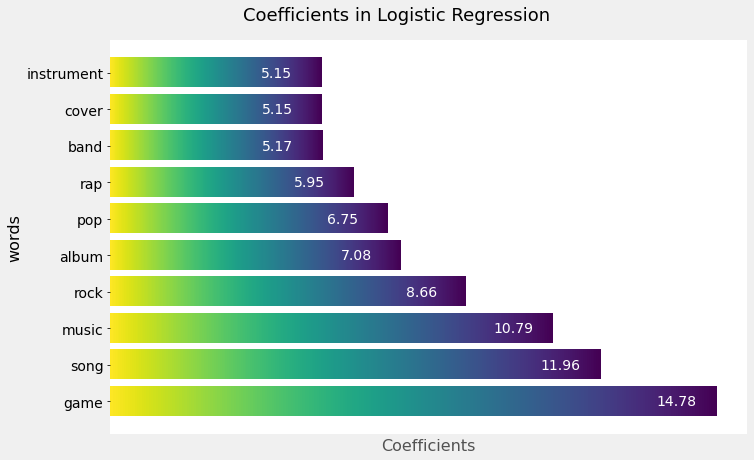

In [120]:
import matplotlib as mpl         
# Variables
index = top_10_coef_sorted.index
values = top_10_coef_sorted['coef']
plot_title = 'Coefficients in Logistic Regression'
title_size = 18
x_label = 'Coefficients'
filename = 'barh-plot'

fig, ax = plt.subplots(figsize=(10,6), facecolor=(.94, .94, .94))
mpl.pyplot.viridis()

bar = ax.barh(index, values)
plt.tight_layout()


title = plt.title(plot_title, pad=20, fontsize=title_size)
title.set_position([.45, 1])




def gradientbars(bars):
    grad = np.atleast_2d(np.linspace(0,1,256))
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor('none')
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        ax.imshow(grad, extent=[x+w, x, y, y+h], aspect='auto', zorder=1)
    ax.axis(lim)
gradientbars(bar)


rects = ax.patches
# Place a label for each bar
for rect in rects:
    # Get X and Y placement of label from rect
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label; change to your liking
    space = -60
    # Vertical alignment for positive values
    ha = 'left'

    # If value of bar is negative: place label to the left of the bar
    if x_value < 0:
        # Invert space to place label to the left
        space *= -1
        # Horizontally align label to the right
        ha = 'center'

    # Use X value as label and format number
    label = '{:,.02f}'.format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at bar end
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords='offset points', # Interpret `xytext` as offset in points
        fontsize=14,
        va='center',                # Vertically center label
        ha=ha,                      # Horizontally align label differently for positive and negative values
        color = 'white')            # Change label color to white


#Set x-label
ax.set_xlabel(x_label, color='#525252')

plt.ylabel("words", fontsize=16)
plt.xlabel('Coefficients', fontsize=16)
plt.xticks([])
sns.despine(left=True, bottom=True)
plt.grid(b=None)
plt.yticks(fontsize=14)
plt.grid(False)
plt.show()


### 2- Modeling: Naive Bayes and TFIDF Model

In [122]:
nbayes_tvec_model=MultinomialNB()

nbayes_tvec_model.fit(X_train_tfidf, y_train)

print(f'Naive Bayes and TFIDF Model Score on Training Set :{nbayes_tvec_model.score(X_train_tfidf, y_train)}')
print(f'Logistic Regression and TFIDF Model Score on Testing Set :{nbayes_tvec_model.score(X_test_tfidf, y_test)}')

Naive Bayes and TFIDF Model Score on Training Set :0.9505209265690452
Logistic Regression and TFIDF Model Score on Testing Set :0.9067769305122972


In [123]:
nbayes_params = { 'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001) }  

In [124]:
grid_search_nbayes = GridSearchCV(nbayes_tvec_model, nbayes_params,
                                  scoring="accuracy", n_jobs=-1, return_train_score=True)

grid_search_nbayes.fit(X_train_tfidf, y_train)

GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05)},
             return_train_score=True, scoring='accuracy')

/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


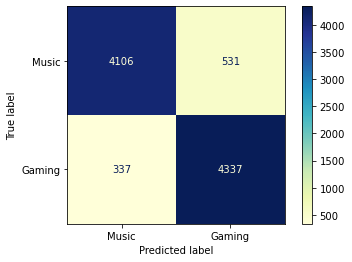

In [125]:
plot_confusion_matrix(nbayes_tvec_model, X_test_tfidf, y_test, cmap='YlGnBu', display_labels=['Music', 'Gaming']);
plt.grid(b=None);
plt.grid(False)

In [126]:
grid_search_nbayes.best_params_

{'alpha': 1}

In [127]:
train_pred_nbayes = grid_search_nbayes.predict(X_train_tfidf)
test_pred_nbayes = grid_search_nbayes.predict(X_test_tfidf)

auc=roc_auc_score(y_test, test_pred_nbayes)
acc = accuracy_score(y_test, test_pred_nbayes )
prec = precision_score(y_test, test_pred_nbayes)
rec = recall_score(y_test, test_pred_nbayes )
f1 = f1_score(y_test, test_pred_nbayes)

results_nbayes = pd.DataFrame([['Naive Bayes-TFIDF',  acc,auc, prec, rec, f1]], 
                           columns = ['Model','Accuracy','AUC', 'Precision', 'Recall', 'F1 Score'])

results = results.append(results_nbayes, ignore_index = True)
results = results.sort_values(["Accuracy","AUC","Precision", "Recall"], ascending = False)
results

<ipython-input-127-31b07104a193>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(results_nbayes, ignore_index = True)


,Model,Accuracy,AUC,Precision,Recall,F1 Score
1,Naive Bayes-TFIDF,0.906777,0.906693,0.890920,0.927899,0.909034
0,Logistic Regression-TFIDF,0.906670,0.906589,0.891541,0.926829,0.908843


### Preprocessing: Count Vectorizer with ngrams

In [128]:
cv_4=CountVectorizer(stop_words=STOP_WORDS, ngram_range=[1, 4])

In [129]:
X_train_cv_4=cv_4.fit_transform(X_train)

In [130]:
X_test_cv_4=cv_4.transform(X_test)

In [131]:
cv_4_df= pd.DataFrame(X_train_cv_4.todense(),
                     columns=cv_4.get_feature_names())

cv_4_df.head()

/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,__,__ song,__ song week,__ song week update_,__ video,___,___ time,___________,___________ rock,___________ rock roll,...,zz gimme lovin chraz,zzjydoqne,zzjydoqne orqylya,zzz,zzz going,zzz going ft,zzz going ft turbo,zzz running,zzz running away,zzz running away altpop
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3- Modeling: Logistic Regression and CountVectorizer Model

In [132]:
lr_cv4=LogisticRegression()

lr_cv4.fit(X_train_cv_4, y_train)

print(f'Logistic Regression and CountVectorizer Model Score on Training Set :{lr_cv4.score(X_train_cv_4, y_train)}')
print(f'Logistic Regression and CountVectorizer Model Score on Testing Set :{lr_cv4.score(X_test_cv_4, y_test)}')

Logistic Regression and CountVectorizer Model Score on Training Set :0.9863592424188178
Logistic Regression and CountVectorizer Model Score on Testing Set :0.9098915261518634


/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


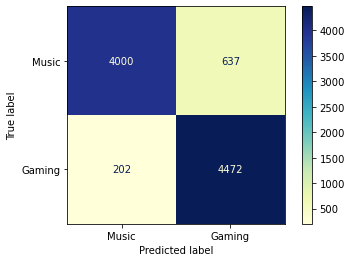

In [133]:
plot_confusion_matrix(lr_cv4, X_test_cv_4, y_test, cmap='YlGnBu', display_labels=['Music', 'Gaming'])
plt.grid(b=None)
plt.grid(False)

In [134]:
train_pred_lr2 = lr_cv4.predict(X_train_cv_4)
test_pred_lr2 = lr_cv4.predict(X_test_cv_4)

auc=roc_auc_score(y_test, test_pred_lr2)
acc = accuracy_score(y_test, test_pred_lr2 )
prec = precision_score(y_test, test_pred_lr2)
rec = recall_score(y_test, test_pred_lr2 )
f1 = f1_score(y_test, test_pred_lr2)

results_lr2 = pd.DataFrame([['Logstic Regression-CV',  acc,auc, prec, rec, f1]], 
                           columns = ['Model','Accuracy','AUC', 'Precision', 'Recall', 'F1 Score'])

results = results.append(results_lr2, ignore_index = True)
results = results.sort_values(["Accuracy","AUC","Precision", "Recall"], ascending = False)
results

<ipython-input-134-b26c15fdb962>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(results_lr2, ignore_index = True)


,Model,Accuracy,AUC,Precision,Recall,F1 Score
2,Logstic Regression-CV,0.909892,0.909704,0.875318,0.956782,0.914239
0,Naive Bayes-TFIDF,0.906777,0.906693,0.890920,0.927899,0.909034
1,Logistic Regression-TFIDF,0.906670,0.906589,0.891541,0.926829,0.908843


### 4- Modeling: Naive Bayes and CountVectorizer Model

In [135]:
nbayes_cv_4=MultinomialNB()

nbayes_cv_4.fit(X_train_cv_4, y_train)

print(f'Naive Bayes and cvec Model Score on Training Set :{nbayes_cv_4.score(X_train_cv_4, y_train)}')
print(f'Logistic Regression and cvec Model Score on Testing Set :{nbayes_cv_4.score(X_test_cv_4, y_test)}')

Naive Bayes and cvec Model Score on Training Set :0.9834592388385665
Logistic Regression and cvec Model Score on Testing Set :0.9246053055525723


/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


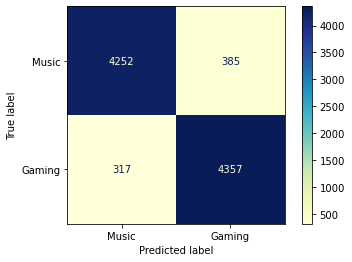

In [136]:
plot_confusion_matrix(nbayes_cv_4, X_test_cv_4, y_test, cmap='YlGnBu', display_labels=['Music', 'Gaming']);
plt.grid(b=None)
plt.grid(False)

In [137]:
train_pred_nb2 = nbayes_cv_4.predict(X_train_cv_4)
test_pred_nb2 = nbayes_cv_4.predict(X_test_cv_4)

auc=roc_auc_score(y_test, test_pred_nb2)
acc = accuracy_score(y_test, test_pred_nb2 )
prec = precision_score(y_test, test_pred_nb2)
rec = recall_score(y_test, test_pred_nb2 )
f1 = f1_score(y_test, test_pred_nb2)

results_nb2 = pd.DataFrame([['Naive Bayes-CV',  acc,auc, prec, rec, f1]], 
                           columns = ['Model','Accuracy','AUC', 'Precision', 'Recall', 'F1 Score'])

results = results.append(results_nb2, ignore_index = True)
results = results.sort_values(["Accuracy","AUC","Precision", "Recall"], ascending = False)
results

<ipython-input-137-b21ff096103d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(results_nb2, ignore_index = True)


,Model,Accuracy,AUC,Precision,Recall,F1 Score
3,Naive Bayes-CV,0.924605,0.924575,0.918811,0.932178,0.925446
0,Logstic Regression-CV,0.909892,0.909704,0.875318,0.956782,0.914239
1,Naive Bayes-TFIDF,0.906777,0.906693,0.890920,0.927899,0.909034
2,Logistic Regression-TFIDF,0.906670,0.906589,0.891541,0.926829,0.908843


###  Let's initiate and fit the model through GridSearchCV and Pipe

In [138]:
nbayes=MultinomialNB()
pipe=make_pipeline(tfidf, nbayes)
pipe

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(stop_words={"'d", "'ll", "'m", "'re", "'s",
                                             "'ve", '`', 'a', 'about', 'above',
                                             'across', 'after', 'afterwards',
                                             'again', 'against', 'ai', 'all',
                                             'almost', 'alone', 'along',
                                             'already', 'also', 'although',
                                             'always', 'am', 'among', 'amongst',
                                             'amount', 'an', 'and', ...},
                                 tokenizer=<function textblob_tokenizer at 0x7fc0763b5f70>)),
                ('multinomialnb', MultinomialNB())])

In [139]:
params={
       'tfidfvectorizer__max_features': [2000, 3000, 4000, 5000], 
          'tfidfvectorizer__stop_words': [STOP_WORDS, None],
         'tfidfvectorizer__ngram_range': [(1, 2), (1, 1)]
    }

In [140]:
#grid
grid=GridSearchCV(pipe, param_grid=params)
#fit it
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words={"'d", "'ll",
                                                                    "'m", "'re",
                                                                    "'s", "'ve",
                                                                    '`', 'a',
                                                                    'about',
                                                                    'above',
                                                                    'across',
                                                                    'after',
                                                                    'afterwards',
                                                                    'again',
                                                                    'against',
                                                                    'ai', 'all',
                                                                    'almost',
                                                                    'alone',
                                                                    'along',
                                                                    'already',
                                                                    'also',
                                                                    'although',
                                                                    'always',
                                                                    'am',
                                                                    'among',
                                                                    'amongst',
                                                                    'amount',
                                                                    'an', 'and', ...},
                                                        tokenizer=<function textblob_tokenizer a...
             param_grid={'tfidfvectorizer__max_features': [2000, 3000, 4000,
                                                           5000],
                         'tfidfvectorizer__ngram_range': [(1, 2), (1, 1)],
                         'tfidfvectorizer__stop_words': [{"'d", "'ll", "'m",
                                                          "'re", "'s", "'ve",
                                                          '`', 'a', 'about',
                                                          'above', 'across',
                                                          'after', 'afterwards',
                                                          'again', 'against',
                                                          'ai', 'all', 'almost',
                                                          'alone', 'along',
                                                          'already', 'also',
                                                          'although', 'always',
                                                          'am', 'among',
                                                          'amongst', 'amount',
                                                          'an', 'and', ...},
                                                         None]})

In [141]:
# Score model on training and testing set.
print(f'Grid model score on training data: {grid.score(X_train, y_train)}')
print(f'Grid model score on testing data: {grid.score(X_test, y_test)}')

Grid model score on training data: 0.9205542229064481
Grid model score on testing data: 0.8942111481043926


/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


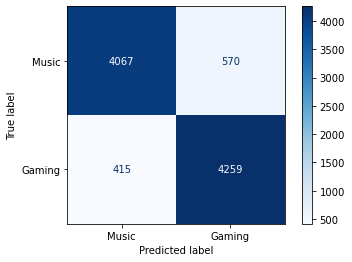

In [142]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# Get predictions
preds = grid.predict(X_test)
# Save confusion matrix values
cmat2 = confusion_matrix(y_test, preds)
plot_confusion_matrix(grid,  X_test, y_test,cmap='Blues', display_labels=['Music', 'Gaming']);
plt.grid(False)

### 5- Random Forest Classifier Model with TFIDF

> Use the random grid to search for best hyperparameters m Random search of parameters, using 5 fold cross validation,search across 100 different combinations, and use all available cores

In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [144]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [145]:
param_grid_rfc = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [146]:
# rfc=RandomForestClassifier()

# random_search = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid_rfc,
#                                n_iter = 100, cv = 5, verbose=2, random_state=42, 
#                                n_jobs = -1)

#### the best parameters from fitting the random search

In [147]:
# #the best parameters from fitting the random search
# random_search.fit(X_train_tfidf, y_train)
# print(random_search.best_estimator_)

### Grid Search with Cross Validation

In [148]:
rf_tdif=RandomForestClassifier(bootstrap=False, max_features='sqrt')

rf_tdif.fit(X_train_tfidf, y_train)

RandomForestClassifier(bootstrap=False)

### Evaluating the model

In [149]:
train_pred_rf_tdif = rf_tdif.predict(X_train_tfidf)
test_pred_rf_tdif = rf_tdif.predict(X_test_tfidf)

In [150]:
auc=roc_auc_score(y_test, test_pred_rf_tdif)
acc = accuracy_score(y_test, test_pred_rf_tdif) 
prec = precision_score(y_test, test_pred_rf_tdif )
rec = recall_score(y_test, test_pred_rf_tdif )
f1 = f1_score(y_test, test_pred_rf_tdif )


In [151]:
auc=roc_auc_score(y_test, test_pred_rf_tdif)
acc = accuracy_score(y_test, test_pred_rf_tdif )
prec = precision_score(y_test, test_pred_rf_tdif)
rec = recall_score(y_test, test_pred_rf_tdif )
f1 = f1_score(y_test, test_pred_rf_tdif)

results_rf_tdif = pd.DataFrame([['Random Forest_TDIF',  acc,auc, prec, rec, f1]], 
                           columns = ['Model','Accuracy','AUC', 'Precision', 'Recall', 'F1 Score'])

results = results.append(results_rf_tdif, ignore_index = True)
results = results.sort_values(["Accuracy","AUC","Precision", "Recall"], ascending = False)
results

<ipython-input-151-c667b950d58a>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(results_rf_tdif, ignore_index = True)


,Model,Accuracy,AUC,Precision,Recall,F1 Score
0,Naive Bayes-CV,0.924605,0.924575,0.918811,0.932178,0.925446
1,Logstic Regression-CV,0.909892,0.909704,0.875318,0.956782,0.914239
2,Naive Bayes-TFIDF,0.906777,0.906693,0.890920,0.927899,0.909034
3,Logistic Regression-TFIDF,0.906670,0.906589,0.891541,0.926829,0.908843
4,Random Forest_TDIF,0.890130,0.889999,0.866787,0.922978,0.894001


### So the best result is for Naive Bayes with count vectorizer with 92% accuracy for test score and 98% accuracy for training score.

In [152]:
print(f'Naive Bayes and cvec Model Score on Training Set :{nbayes_cv_4.score(X_train_cv_4, y_train)}')
print(f'Logistic Regression and cvec Model Score on Testing Set :{nbayes_cv_4.score(X_test_cv_4, y_test)}')

Naive Bayes and cvec Model Score on Training Set :0.9834592388385665
Logistic Regression and cvec Model Score on Testing Set :0.9246053055525723


# Thanks